In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from os.path import join
import glob
import os

# James's path
training_prefix='/content/drive/My Drive/large_dataset/training/'
test_prefix='/content/drive/My Drive/large_dataset/validation/'

def load_data_from_files_with_id(prefix):
    prefix = prefix.rstrip(os.sep)
    files = [f for f in glob.iglob(join(prefix, join('**', '*.csv')), recursive=True)]
    print("Loading data from {} files...".format(len(files)))

    df_list = []
    #for i in range(len(files)):
    for i in range(10):
      df = pd.read_csv(files[i], header = 0)
      idx = [i] * df.shape[0]
      df['id'] = idx

      fname = os.path.splitext(os.path.split(files[i])[1])[0]
     # print('name is {}' .format(fname))
      df['filename'] = fname
      df_list.append(df)

    return pd.concat(df_list)

def process_data(data):
  data = data.set_index('id')
  unique_ids = data.index.unique()
  return data, unique_ids

In [0]:
train = load_data_from_files_with_id(training_prefix)
test = load_data_from_files_with_id(test_prefix)

train, train_ids = process_data(train)
test, test_ids = process_data(test)

print(train.shape, test.shape)

Loading data from 798 files...
Loading data from 150 files...
(1988, 16) (1982, 16)


In [0]:
print(train.head)

<bound method NDFrame.head of            vx  ...                                           filename
id             ...                                                   
0  -10.954589  ...  training_0000_segment-10526338824408452410_571...
0  -10.930109  ...  training_0000_segment-10526338824408452410_571...
0  -10.861781  ...  training_0000_segment-10526338824408452410_571...
0  -10.822652  ...  training_0000_segment-10526338824408452410_571...
0  -10.776157  ...  training_0000_segment-10526338824408452410_571...
..        ...  ...                                                ...
9  -10.408837  ...  training_0000_segment-11799592541704458019_982...
9  -10.646922  ...  training_0000_segment-11799592541704458019_982...
9  -10.894691  ...  training_0000_segment-11799592541704458019_982...
9  -11.166045  ...  training_0000_segment-11799592541704458019_982...
9  -11.391324  ...  training_0000_segment-11799592541704458019_982...

[1988 rows x 16 columns]>


In [0]:
#train['filename'].head()
train.to_csv(os.getcwd()+'/drive/My Drive/testtest.csv', index = None, header = True)


In [0]:
def append_lag_features_for_single_id(single_data, feat_names, prev_n):
  data = single_data.copy()

  lag_feat = pd.DataFrame(single_data[feat_names].copy())

  for feat_name in feat_names:
    for i in range(1, prev_n + 1):
      data['{}_lag_{}'.format(feat_name, i)] = lag_feat[feat_name].shift(i)

  return data.dropna()

def append_lag_features(ori_data, uniq_ids, feat_names, prev_n):
  df_list = []
  for identifier in uniq_ids:
    single_data = ori_data.loc[identifier] #1
    processed_data = append_lag_features_for_single_id(single_data, feat_names, prev_n)
    df_list.append(processed_data)

  return pd.concat(df_list)
  

In [0]:
prev_n = 2
lag_feats = ['vx', 'vy', 'vz']

train_lagged = append_lag_features(train, train_ids, lag_feats, prev_n)
test_lagged = append_lag_features(test, test_ids, lag_feats, prev_n)

print(train_lagged.shape, test_lagged.shape)


(1968, 22) (1962, 22)


In [0]:
import pandas as pd
import numpy as np
import xgboost
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [0]:
train = train_lagged
test = test_lagged

In [0]:
X = train.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels', 
                 'vx_lag_2', 'vy_lag_2', 'vz_lag_2']]
Y_ax = train.loc[:,['ax']].values.ravel() # flatten to 1d array
Y_ay = train.loc[:,['ay']].values.ravel()
Y_az = train.loc[:,['az']].values.ravel()

# y = Y_ax
X_train_ax, X_test_ax, y_train_ax, y_test_ax = train_test_split(X, Y_ax)
X_train_ay, X_test_ay, y_train_ay, y_test_ay = train_test_split(X, Y_ay)
X_train_az, X_test_az, y_train_az, y_test_az = train_test_split(X, Y_az)

X_test = test.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',      
                 'vx_lag_2', 'vy_lag_2', 'vz_lag_2']]
Y_test_ax = test.loc[:, ['ax']].values.ravel()
Y_test_ay = test.loc[:, ['ay']].values.ravel()
Y_test_az = test.loc[:, ['az']].values.ravel()

print("X_train_ax shape: {}, X_test_ax shape:{}".format(X_train_ax.shape, X_test_ax.shape))
print("y_train_ax shape: {}, y_test_ax shape:{}".format(y_train_ax.shape, y_test_ax.shape))

print("X_train_ay shape: {}, X_test_ay shape:{}".format(X_train_ay.shape, X_test_ay.shape))
print("y_train_ay shape: {}, y_test_ay shape:{}".format(y_train_ay.shape, y_test_ay.shape))

print("X_train_az shape: {}, X_test_az shape:{}".format(X_train_az.shape, X_test_az.shape))
print("y_train_az shape: {}, y_test_az shape:{}".format(y_train_az.shape, y_test_az.shape))

X_train_ax shape: (1476, 15), X_test_ax shape:(492, 15)
y_train_ax shape: (1476,), y_test_ax shape:(492,)
X_train_ay shape: (1476, 15), X_test_ay shape:(492, 15)
y_train_ay shape: (1476,), y_test_ay shape:(492,)
X_train_az shape: (1476, 15), X_test_az shape:(492, 15)
y_train_az shape: (1476,), y_test_az shape:(492,)


In [0]:
X_train_ay.head()
s_scaler = RobustScaler()
X_train_ay = pd.DataFrame(s_scaler.fit_transform(X_train_ay), 
                          index=X_train_ay.index, 
                          columns=X_train_ay.columns)
X_test_ay = pd.DataFrame(s_scaler.fit_transform(X_test_ay), 
                          index=X_test_ay.index, 
                          columns=X_test_ay.columns)

X_train_ay.head()
X_test_ay.head()
X_test_az.head()

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,vx_lag_2,vy_lag_2,vz_lag_2
id,,,,,,,,,,,,,,,
2,-2.618572,-3.919568,-0.006162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.0,-2.637502,-3.939376,-0.008252
1,0.000000,0.000000,0.000000,56.560903,1.665060,0.005998,0.009748,0.000169,0.156712,-0.008471,-0.000685,44.0,0.000000,0.000000,0.000000
3,-0.045984,3.817424,-0.004679,48.110110,-0.974022,-2.112336,-6.274364,0.114613,22.945292,-33.648401,-0.965865,49.0,-0.044002,3.897783,0.001572
3,-0.040740,3.441107,-0.009286,39.744171,-1.368074,0.121103,-7.792886,0.030393,-0.003508,0.076732,-0.128763,51.0,-0.042740,3.550774,-0.012964
8,0.105600,0.491104,0.008724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.0,0.098556,0.476328,-0.003605


In [0]:
#X
X_train_ax.head()
s_scaler = RobustScaler()
X_train_ax = pd.DataFrame(s_scaler.fit_transform(X_train_ax), 
                          index=X_train_ax.index, 
                          columns=X_train_ax.columns)
X_test_ax = pd.DataFrame(s_scaler.fit_transform(X_test_ax), 
                          index=X_test_ax.index, 
                          columns=X_test_ax.columns)
#Y
X_train_ax.head()
X_test_ax.head()

X_train_az.head()
s_scaler = RobustScaler()
X_train_az = pd.DataFrame(s_scaler.fit_transform(X_train_az), 
                          index=X_train_az.index, 
                          columns=X_train_az.columns)
X_test_az = pd.DataFrame(s_scaler.fit_transform(X_test_az), 
                          index=X_test_az.index, 
                          columns=X_test_az.columns)
#Z
X_train_az.head()
X_test_az.head()



,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,vx_lag_2,vy_lag_2,vz_lag_2
id,,,,,,,,,,,,,,,
2,-0.978468,-0.984996,-0.038509,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.060606,-0.948869,-0.981839,-0.080954
1,0.056698,0.000000,0.135223,2.444050,1.665060,0.005998,0.009748,3.096393e+11,0.156712,-0.008471,-0.000685,0.878788,0.058133,0.000000,0.125946
3,0.038520,0.959327,0.003322,2.078883,-0.974022,-2.112336,-6.274364,2.103073e+14,22.945292,-33.648401,-0.965865,1.030303,0.041333,0.971472,0.165360
3,0.040593,0.864758,-0.126581,1.717383,-1.368074,0.121103,-7.792886,5.576922e+13,-0.003508,0.076732,-0.128763,1.090909,0.041815,0.884985,-0.199100
8,0.098444,0.123415,0.381184,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.848485,0.095762,0.118719,0.035565


,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,vx_lag_2,vy_lag_2,vz_lag_2
id,,,,,,,,,,,,,,,
332,0.000000,0.000000,0.000000,0.160374,16.998677,8.263371e-11,1.393209e-01,-1.204872e-01,0.000000,0.00000,0.000000,-0.423077,0.000000,0.000000,0.000000
54,-0.920489,-1.951798,-0.402119,-0.315454,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,-0.961538,-0.894475,-1.917777,-0.501284
696,1.589820,-0.980008,-0.327045,-0.315454,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,-0.769231,1.671113,-0.847054,-0.409396
483,-0.330436,-0.012068,0.061153,1.204107,-35.372407,7.491274e+02,7.509785e+10,-1.140106e+11,2.098405,-0.01089,0.030037,2.076923,-0.489374,-0.006113,0.169325
739,0.225396,0.018583,-0.169564,-0.315454,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.269231,0.284462,0.027023,-0.208417


In [0]:
# GPU
model_XGB_ax_regressor = xgboost.XGBRegressor(
        gamma=0.05,learning_rate=0.05, max_depth=3,
        n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85, 
        tree_method='gpu_hist', gpu_id=0)

# CPU

#X
model_XGB_ax_regressor = xgboost.XGBRegressor(
        gamma=0.05,learning_rate=0.05, max_depth=3,
        n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

model_XGB_ax_regressor.fit(X_train_ax, y_train_ax,
        eval_set=[(X_train_ax, y_train_ax), (X_test_ax, y_test_ax)],
        early_stopping_rounds=50, verbose=False)


#Y
model_XGB_ay_regressor = xgboost.XGBRegressor(
        gamma=0.05,learning_rate=0.05, max_depth=3,
        n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

model_XGB_ay_regressor.fit(X_train_ay, y_train_ay,
        eval_set=[(X_train_ay, y_train_ay), (X_test_ay, y_test_ay)],
        early_stopping_rounds=50, verbose=False)

#Z
model_XGB_az_regressor = xgboost.XGBRegressor(
        gamma=0.05,learning_rate=0.05, max_depth=3,
        n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

model_XGB_az_regressor.fit(X_train_az, y_train_az,
         eval_set=[(X_train_az, y_train_az), (X_test_az, y_test_az)],
        early_stopping_rounds=50, verbose=False)

[20:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=0.85, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

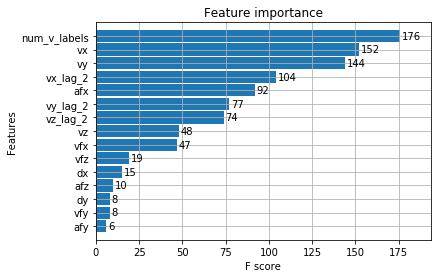

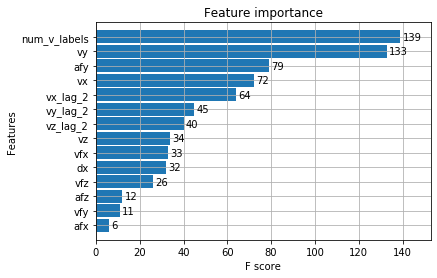

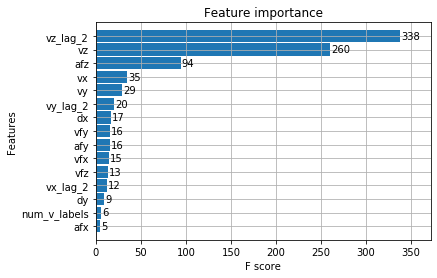

In [0]:
from xgboost import plot_importance

_ = plot_importance(model_XGB_ax_regressor, height=0.9)


from xgboost import plot_importance

_ = plot_importance(model_XGB_ay_regressor, height=0.9)



from xgboost import plot_importance

_ = plot_importance(model_XGB_az_regressor, height=0.9)








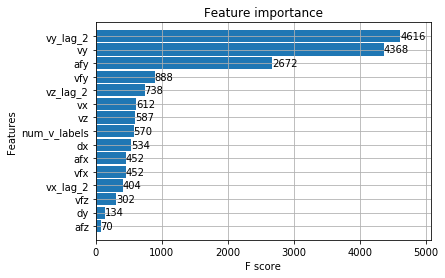

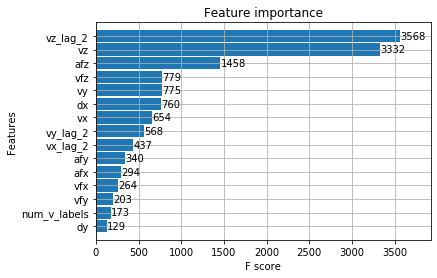

In [0]:

#X
model_name = "baseline"
yx_label = "ax"

print("Predicting {} on test data..".format(model_name))
pred_Yx = model_XGB_ax_regressor.predict(X_test)
print("MAE of {} for {} is {}".format(model_name, yx_label, mean_absolute_error(pred_Y, Y_test_ax)))


#Y
model_name = "baseline"
yy_label = "ay"

print("Predicting {} on test data..".format(model_name))
pred_Yy = model_XGB_ay_regressor.predict(X_test)
print("MAE of {} for {} is {}".format(model_name, yy_label, mean_absolute_error(pred_Yy, Y_test_ay)))


#Z
model_name = "baseline"
yz_label = "az"

print("Predicting {} on test data..".format(model_name))
pred_Yz = model_XGB_az_regressor.predict(X_test)
print("MAE of {} for {} is {}".format(model_name, yz_label, mean_absolute_error(pred_Yz, Y_test_az)))




Predicting baseline on test data..
MAE of baseline for ax is 1.0935959478322088
Predicting baseline on test data..
MAE of baseline for ay is 0.40743697418431707
Predicting baseline on test data..
MAE of baseline for az is 0.08138346108315761


Predicting baseline on test data..
MAE of baseline for ay is 0.3697459076832314


Predicting baseline on test data..
MAE of baseline for az is 0.14697226609439867


In [0]:
test['pred_ax'] = pred_Yx #ax prediction

test['pred_ay'] = pred_Yy #ay prediction

test['pred_az'] = pred_Yz #az prediction

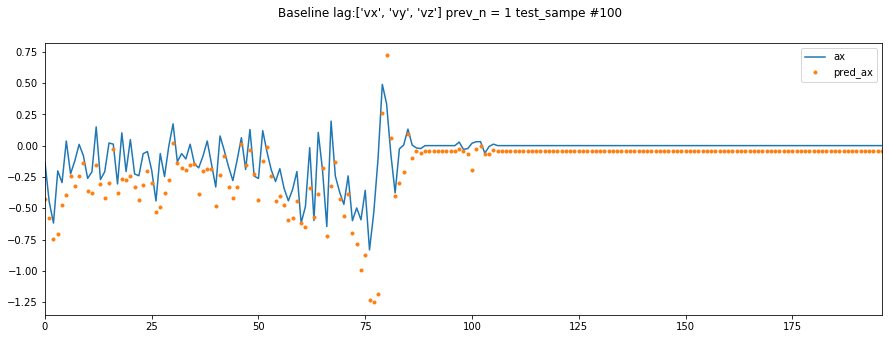

In [0]:
import matplotlib.pyplot as plt

sub_test = test.loc[0]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline lag:['vx', 'vy', 'vz'] prev_n = 1 test_sampe #100")

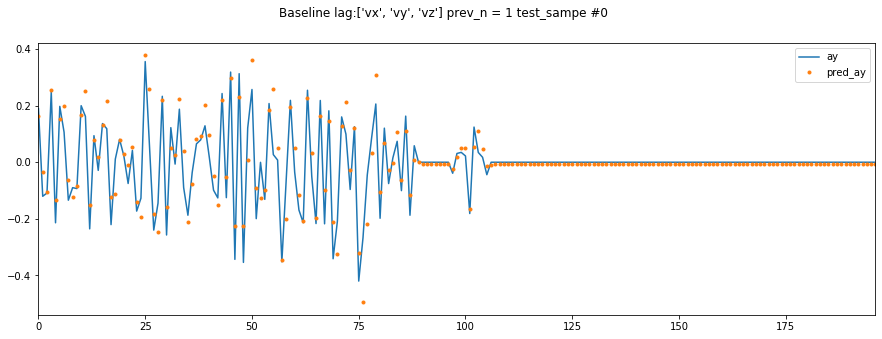

In [0]:
import matplotlib.pyplot as plt

sub_test = test.loc[0]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ay', 'pred_ay']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline lag:['vx', 'vy', 'vz'] prev_n = 1 test_sampe #0")

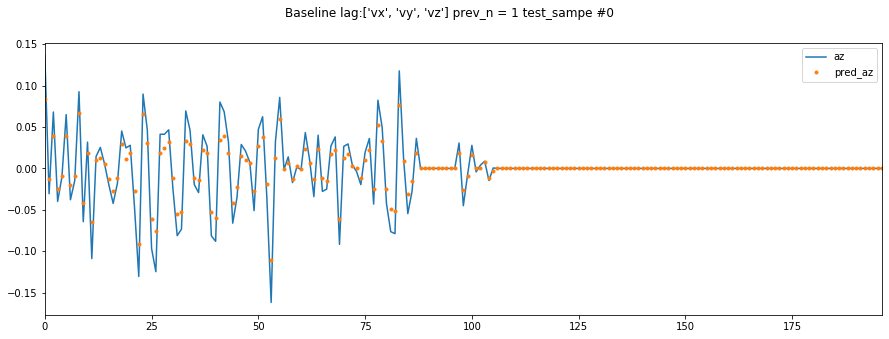

In [0]:
import matplotlib.pyplot as plt

sub_test = test.loc[0]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['az', 'pred_az']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline lag:['vx', 'vy', 'vz'] prev_n = 1 test_sampe #0")



In [0]:
import matplotlib.pyplot as plt

sub_test = test.loc[0]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['az', 'pred_az']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline lag:['vx', 'vy', 'vz'] prev_n = 1 test_sampe #0")


In [0]:
train.to_csv(r'training_large_vx_vy_vz_2.csv', index = None, header = True)
test.to_csv(r'validation_large_vx_vy_vz_2.csv', index = None, header = True)

In [0]:
pd.read_csv('training_large_vx_vy_vz_2.csv')

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az,vx_lag_1,vx_lag_2,vy_lag_1,vy_lag_2,vz_lag_1,vz_lag_2
0,-10.861781,-2.179386,-0.006538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-0.679845,0.268508,0.006225,-10.930109,-10.954589,-2.152400,-2.117917,-0.005913,0.012756
1,-10.822652,-2.210152,-0.011221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.389326,0.306114,0.046590,-10.861781,-10.930109,-2.179386,-2.152400,-0.006538,-0.005913
2,-10.776157,-2.238142,-0.011096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.462608,0.278494,-0.001239,-10.822652,-10.861781,-2.210152,-2.179386,-0.011221,-0.006538
3,-10.738884,-2.270775,-0.017484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.370861,0.324686,0.063559,-10.776157,-10.822652,-2.238142,-2.210152,-0.011096,-0.011221
4,-10.702093,-2.299289,-0.027242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.366060,0.283704,0.097093,-10.738884,-10.776157,-2.270775,-2.238142,-0.017484,-0.011096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156760,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
156761,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
156762,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
156763,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
train.to_csv(os.getcwd()+'/drive/My Drive/training_large_vx_vy_vz_2.csv', index = None, header = True)
test.to_csv(os.getcwd()+'/drive/My Drive/validation_large_vx_vy_vz_2.csv', index = None, header = True)

In [0]:
pd.read_csv('validation_large_vx_vy_vz_2.csv')

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az,vx_lag_1,vx_lag_2,vy_lag_1,vy_lag_2,vz_lag_1,vz_lag_2,pred_ax
0,-1.526878,-0.108901,-0.017838,19.787335,1.781145,1.513234,0.096556,0.017846,0.131049,-0.189679,-0.136688,27.0,-0.131177,0.189820,0.136591,-1.540062,-1.602124,-0.089823,-0.096249,-0.004110,-0.000290,-0.429615
1,-1.481712,-0.096803,-0.014761,19.638062,1.751421,1.468087,0.084437,0.014786,0.449209,0.120582,0.030447,27.0,-0.449395,-0.120376,-0.030618,-1.526878,-1.540062,-0.108901,-0.089823,-0.017838,-0.004110,-0.581069
2,-1.419567,-0.085859,-0.021610,19.492854,1.733913,1.405953,0.073481,0.021631,0.618209,0.109016,-0.068107,27.0,-0.618327,-0.108886,0.068148,-1.481712,-1.526878,-0.096803,-0.108901,-0.014761,-0.017838,-0.744962
3,-1.399296,-0.110872,-0.017601,19.351571,1.713411,1.385692,0.098483,0.017623,0.201597,-0.248766,0.039882,28.0,-0.201692,0.248871,-0.039894,-1.419567,-1.481712,-0.085859,-0.096803,-0.021610,-0.014761,-0.705824
4,-1.369596,-0.089351,-0.016559,19.215781,1.675868,1.356016,0.076936,0.016581,0.295266,0.214385,0.010370,28.0,-0.295503,-0.214125,-0.010365,-1.399296,-1.419567,-0.110872,-0.085859,-0.017601,-0.021610,-0.476441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29449,-1.923419,-0.322495,0.059048,69.012467,-0.094245,15.792535,4.888148,-0.398034,1.200423,0.300160,-0.103191,47.0,-0.323315,-0.014256,-0.029179,-1.955914,-1.993606,-0.323928,-0.336358,0.056116,0.060451,-1.003265
29450,-1.901652,-0.304682,0.057462,70.270082,-0.108454,15.681368,4.845589,-0.379893,1.106087,0.423457,-0.180500,47.0,-0.216583,-0.177239,0.015783,-1.923419,-1.955914,-0.322495,-0.323928,0.059048,0.056116,-0.790866
29451,-1.873572,-0.322392,0.070198,71.528363,-0.113085,15.565707,4.833287,-0.371563,1.150789,0.122396,-0.082885,47.0,-0.279390,0.176217,-0.126717,-1.901652,-1.923419,-0.304682,-0.322495,0.057462,0.059048,-0.685175
29452,-1.828015,-0.300837,0.075184,72.785854,-0.121559,15.432101,4.784423,-0.332834,1.329349,0.486191,-0.385343,48.0,-0.453277,-0.214471,-0.049615,-1.873572,-1.901652,-0.322392,-0.304682,0.070198,0.057462,-0.853309


In [0]:
print(os.getcwd()+'/drive/My Drive/training_large_vx_vy_vz_2.csv')

/content/drive/My Drive/training_large_vx_vy_vz_2.csv


In [0]:
print(test)

test.to_csv(os.getcwd()+'/drive/My Drive/test_results.csv', index = None, header = True)

#print( test.loc[1])


          vx         vy        vz  ...   pred_ax   pred_ay   pred_az
id                                 ...                              
0  -1.526878  -0.108901 -0.017838  ...  1.503576  0.048024  0.091087
0  -1.481712  -0.096803 -0.014761  ...  1.434451  0.048024  0.001586
0  -1.419567  -0.085859 -0.021610  ...  1.401165  0.048024  0.032186
0  -1.399296  -0.110872 -0.017601  ...  1.470291  0.048024  0.001586
0  -1.369596  -0.089351 -0.016559  ...  1.423128  0.011303  0.007997
..       ...        ...       ...  ...       ...       ...       ...
9   3.005185  11.583946 -0.133874  ...  1.120189  0.456772 -0.007002
9   3.099654  11.686730 -0.147780  ...  1.120189  0.456772 -0.007002
9   3.194744  11.776173 -0.171306  ...  1.120189  0.456772 -0.007002
9   3.291713  11.845561 -0.184306  ...  1.120189  0.456772 -0.007002
9   3.386601  11.930219 -0.210015  ...  1.096340  0.456772 -0.007002

[1962 rows x 25 columns]


In [0]:
print(test)


          vx         vy        vz  ...   pred_ax   pred_ay   pred_az
id                                 ...                              
0  -1.526878  -0.108901 -0.017838  ...  1.503576  0.048024  0.091087
0  -1.481712  -0.096803 -0.014761  ...  1.434451  0.048024  0.001586
0  -1.419567  -0.085859 -0.021610  ...  1.401165  0.048024  0.032186
0  -1.399296  -0.110872 -0.017601  ...  1.470291  0.048024  0.001586
0  -1.369596  -0.089351 -0.016559  ...  1.423128  0.011303  0.007997
..       ...        ...       ...  ...       ...       ...       ...
9   3.005185  11.583946 -0.133874  ...  1.120189  0.456772 -0.007002
9   3.099654  11.686730 -0.147780  ...  1.120189  0.456772 -0.007002
9   3.194744  11.776173 -0.171306  ...  1.120189  0.456772 -0.007002
9   3.291713  11.845561 -0.184306  ...  1.120189  0.456772 -0.007002
9   3.386601  11.930219 -0.210015  ...  1.096340  0.456772 -0.007002

[1962 rows x 25 columns]
